In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
# import all rdkit needed libraries
import rdkit
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns

In [3]:
def load_data(file):
    df = pd.read_csv(file)
    return df

def get_mol(df):
    df['mol'] = df['SMILES'].apply(rdkit.Chem.MolFromSmiles)
    return df

def feature_extraction(df):
    df['num_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
    df['num_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
    df['exact_mol_wt'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
    df['AI_COO'] = df['mol'].apply(lambda x: Descriptors.fr_Al_COO(x))
    df['morgan_fp'] = df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=124))
    # Can also use ToBitString()
    df['morgan_fp'] = df['morgan_fp'].apply(lambda x: x.ToList())
    # Or Should it be features?
    df['morgan_fp'] = df['morgan_fp'].apply(lambda x: ''.join(str(item) for item in x))

    return df
training = 'Resources/training_smiles.csv'
testing = 'Resources/test_smiles.csv'
df_training = feature_extraction(get_mol(load_data(training)))
df_testing = feature_extraction(get_mol(load_data(testing)))

[16:05:32] WARNING: not removing hydrogen atom without neighbors
[16:06:30] WARNING: not removing hydrogen atom without neighbors


## Data Exploration

In [7]:
df_training.head()

,INDEX,SMILES,ACTIVE,mol,num_atoms,num_heavy_atoms,exact_mol_wt,AI_COO,morgan_fp
0,1,CC(C)N1CC(=O)C(c2nc3ccccc3[nH]2)=C1N,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001DDD6E...,19,19,256.132411,0,0001000010100001011101000000001100000001010000...
1,2,COc1ccc(-c2ccc3c(N)c(C(=O)c4ccc(OC)c(OC)c4)sc3...,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001DDD6E...,30,30,420.114378,0,0011010001000101011000110000100000001000000100...
2,3,CCc1ccc(C(=O)COC(=O)CCc2nc(=O)c3ccccc3[nH]2)cc1,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001DDD6E...,27,27,364.142307,0,0101111100100000110101010000001000000000011110...
3,4,O=C(CN1CCOCC1)Nc1ccc(S(=O)(=O)N2CCCCCC2)cc1,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001DDD6E...,26,26,381.172227,0,0000010000100000010001000000010000011110001001...
4,5,C=CCC(Nc1ccccc1)c1ccc(OC)c(OC)c1,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001DDD6E...,21,21,283.157229,0,0110000001000101010001000000001001000000000100...


In [8]:
df_training.dtypes

INDEX                int64
SMILES              object
ACTIVE             float64
mol                 object
num_atoms            int64
num_heavy_atoms      int64
exact_mol_wt       float64
AI_COO               int64
morgan_fp           object
dtype: object

In [9]:
df_training.count()

INDEX              156258
SMILES             156258
ACTIVE             156258
mol                156258
num_atoms          156258
num_heavy_atoms    156258
exact_mol_wt       156258
AI_COO             156258
morgan_fp          156258
dtype: int64

In [10]:
df_training["ACTIVE"].value_counts()

0.0    154528
1.0      1730
Name: ACTIVE, dtype: int64

Definitely to be considered imbalanced data maybe use Synthetic Minority Over-sampling Technique (SMOT). Random Over-sampling or Under-sampling

In [11]:
df_training.describe()

,INDEX,ACTIVE,num_atoms,num_heavy_atoms,exact_mol_wt,AI_COO
count,156258.000000,156258.000000,156258.000000,156258.000000,156258.000000,156258.000000
mean,78129.500000,0.011071,24.351892,24.351822,348.312620,0.031307
std,45107.943519,0.104637,5.559917,5.559868,78.296593,0.181454
min,1.000000,0.000000,2.000000,2.000000,33.021464,0.000000
25%,39065.250000,0.000000,21.000000,21.000000,294.121572,0.000000
50%,78129.500000,0.000000,24.000000,24.000000,344.173607,0.000000
75%,117193.750000,0.000000,28.000000,28.000000,399.079518,0.000000
max,156258.000000,1.000000,101.000000,101.000000,1447.430200,4.000000


This means that the columns num_atoms, num_heavy_atoms, exact_mol_wt, AI_COO can be normalized. Discreatization can probably be done for num_atoms, num_heavy_atoms, exact_mol_wt but not for AI_COO. There is also a decision to be made regarding weather to keep num_atoms or num_heavy_atoms, since the data is the same in the columns.

In [12]:
df_training.isnull().sum()

INDEX              0
SMILES             0
ACTIVE             0
mol                0
num_atoms          0
num_heavy_atoms    0
exact_mol_wt       0
AI_COO             0
morgan_fp          0
dtype: int64

According to above no features have null values i.e. no imputation needed?

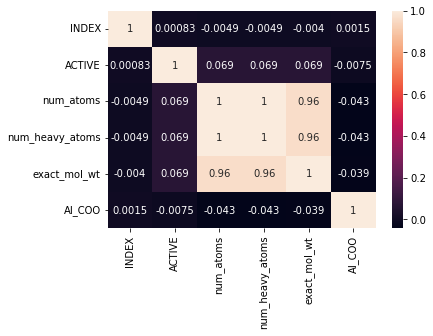

In [16]:
sns.heatmap(df_training.corr(), annot=True)
plt.show()

## Data Preparation

In [61]:
df1_training= df_training.copy()
y = df1_training['ACTIVE']
X = df1_training.drop(columns = 'ACTIVE', axis=1)

# Stratify is used to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)
y_test
# print(len(X_test))
# print(len(y_test))
# print(len(X_train))
# print(len(y_train))

IndexingError: Too many indexers

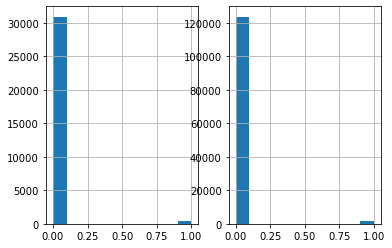

In [67]:
display_test = X_test.copy()
display_train = X_train.copy()

display_test = pd.concat([display_test, y_test], axis=1)
display_train = pd.concat([display_train, y_train], axis=1)

plt.subplot(1,2,1)
display_test['ACTIVE'].hist()
# display_test['exact_mol_wt'].hist()

plt.subplot(1,2,2)
display_train['ACTIVE'].hist()
# display_train['exact_mol_wt'].hist()

plt.show()

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_features = X_train.select_dtypes(include=['float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'bool']).columns
categorical_transformer = Pipeline(steps=[('impute', SimpleImputer(strategy='constant', fill_value="missing")),
                                          ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
numeric_transformer = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                                      ('pca', PCA(n_components=None))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_features),
                                               ('cat', categorical_transformer, cat_features)])

## Build a binary classifier